## Configuration

In [1]:
from collections import Counter

import pandas as pd

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release"
FANMOD_exe = "LocalFANMOD.exe"

raw_data_folder = './../../data'
raw_data_folder_dataset = '/melanoma_distance_100_XX'
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'
results_dir = './../../results/melanoma_distance_100_XX'
motif_size = 4
iterations = 1000
force_run_fanmod = False
force_parse = False

In [2]:
cells_type = {
    0: 'B cell',
    1: 'CD4 APC',
    2: 'CD4 T cell',
    3: 'CD4 Treg',
    4: 'CD8 T cell',
    5: 'DCs',
    6: 'Germinal Center B cell',
    7: 'Hevs',
    8: 'MAC',
    9: 'Memory CD4 T Cell',
    10: 'NK cell',
    11: 'Neutrophil',
    12: 'Stroma',
    13: 'Tumor',
    14: 'Unidentified',
    15: 'Vessels'
}

Distant_metastases_class = {
    'NP': 'NP',
    'NN': 'NN',
    'PN': 'PN',
    'PP': 'PP',
}

class_to_color = {
    'NP': 'green',
    'NN': 'yellow',
    'PN': 'magenta',
    'PP': 'blue',
}

target_classes = ['NN', 'NP']
target_classes_str = 'NN_NP'

## Steps
1. Initiate CISM object
2. Load datasets
3. Initiate CISMTask

In [3]:
from cism.cism import CISM

In [4]:
cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=raw_data_folder,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)

# adding Melanoma dataset
cism.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=8, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [5]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                                                tissue_state_to_string=Distant_metastases_class,
                                                common_cells_type=cells_type)

In [6]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
NN,20
NP,18
PN,13
PP,17


## Figure 2
Context-dependent identification of spatial motifs can predict the state of human melanoma disease

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


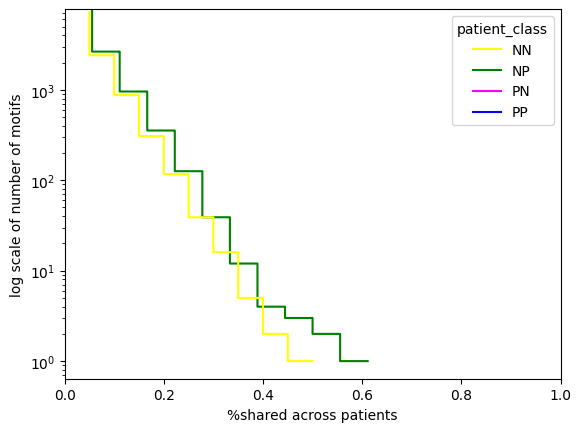

In [8]:
discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=target_classes)

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

In [9]:
# export data to excel
discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +'/number_of_motifs_versus_shared_percentage.csv')

### Performance Diagram
1. Pairwise Learning
2. 3 Nodes Motifs
3. 4 Nodes Motifs
4. 5 Nodes Motifs
5. Permutation tests (for threshold 0.46)
6. GNN Performance

Here we export the data for 1, 4, 5


#### Pairwise Learning

In [6]:
#read graphs
from pairwise.reader import GraphReader

full_graph_df = pd.DataFrame()
full_graph_df = GraphReader.get_graphs(full_graph_df=full_graph_df,
                                       raw_data_folder=raw_data_folder,
                                       raw_data_folder_type=raw_data_folder_dataset,
                                       disease='Melanoma',
                                       cells_type=cells_type)

In [7]:
from pairwise.pairwise_model import PairwiseAnalysis

pairwise_analysis = PairwiseAnalysis(
    tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
    tissue_state_to_string=Distant_metastases_class)

In [10]:
cell_type_counts = pairwise_analysis.get_cell_type_count_from_classes(
                            full_graph_df=full_graph_df,
                            classes=['NN', 'NP','PN'],
                            cells_type=cells_type,
                            normalize=True)
cell_type_counts.to_csv(results_dir +'/NN_NP_PN_cell_type_frequency.csv')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [8]:
group_a_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NN',
                                            cells_type=cells_type)
group_b_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NP',
                                            cells_type=cells_type)

In [9]:
group_a_general_pairwise = group_a_general_pairwise.drop(['Tumor'], axis=1)
group_a_general_pairwise = group_a_general_pairwise.drop(['Tumor'], axis=0)

In [12]:
from scipy import stats
import numpy as np

def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

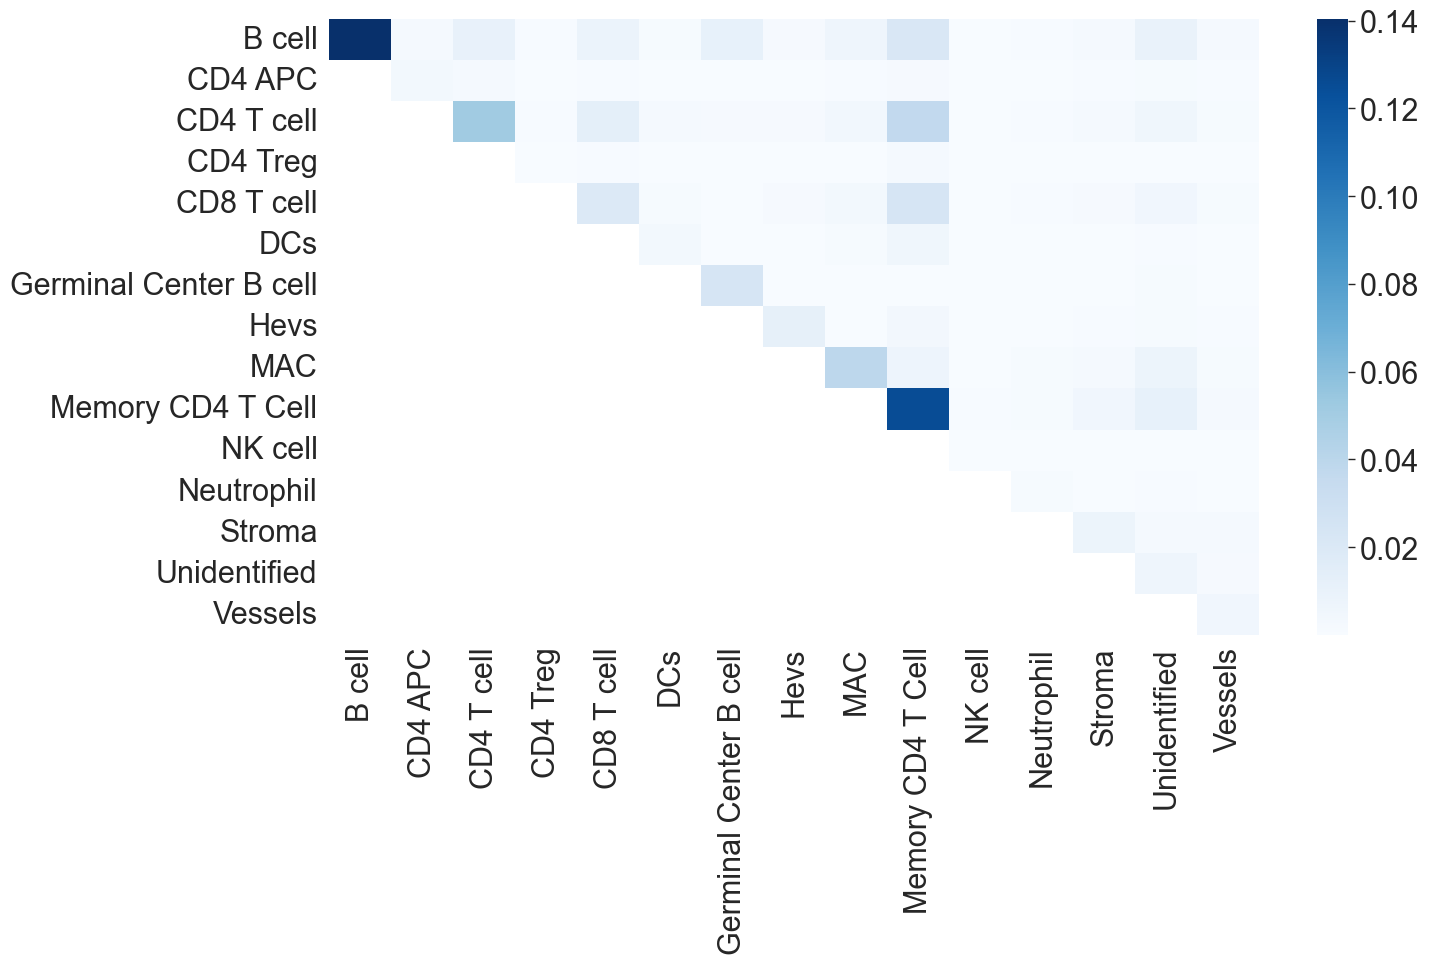

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

ax = sns.heatmap(group_a_general_pairwise, annot=False, mask=np.tril(np.ones_like(group_a_general_pairwise), k=-1), cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [14]:
group_b_general_pairwise = group_b_general_pairwise.drop(['Tumor'], axis=1)
group_b_general_pairwise = group_b_general_pairwise.drop(['Tumor'], axis=0)

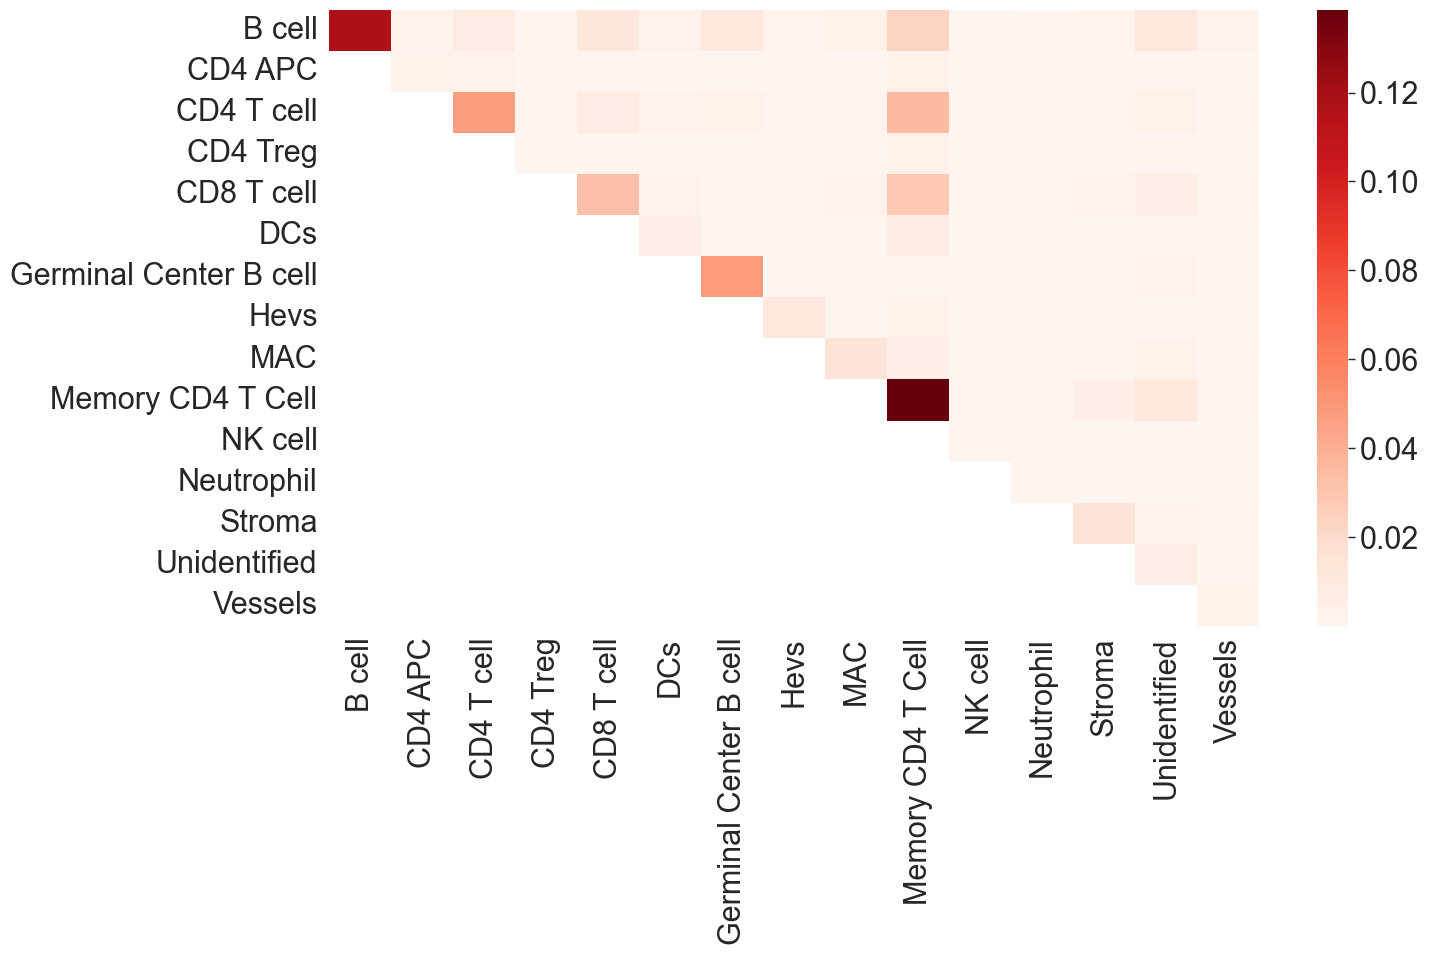

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

ax = sns.heatmap(group_b_general_pairwise, annot=False, mask=np.tril(np.ones_like(group_b_general_pairwise), k=-1), cmap='Reds', annot_kws={'size': 14}, fmt=".3f")

In [15]:
print(f'NN spearman NP:')
print(stats.spearmanr(upper(group_a_general_pairwise), upper(group_b_general_pairwise)))

NN spearman NP:
SignificanceResult(statistic=0.9522703711382956, pvalue=6.849772370557585e-55)


In [9]:
import numpy as np

roc_auc_scores = pairwise_analysis.analyze(full_graph_df=full_graph_df,
                                           cells_type=cells_type,
                                           labels=['NN', 'NP'],
                                           trials=10)

print(f'roc_auc_score - mean: {np.mean(roc_auc_scores)} std: {np.std(roc_auc_scores)}')

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]


KeyboardInterrupt



## 4 Nodes
## Within-motif spatial organization contributes to disease state prediction

In [16]:
shared_percentage_th = 0.46
local_motif_size = 4

In [17]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(
                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                use_cells_type_composition=False,
                use_motifs=True,
                shared_percentage=shared_percentage_th,
                max_class_features=30,
                labels=target_classes)

motif_space_features = discriminator.get_features(feature_conf=featureConf,
                                                          exclude_patients=[],
                                                          n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

FixedFormatter should only be used together with FixedLocator


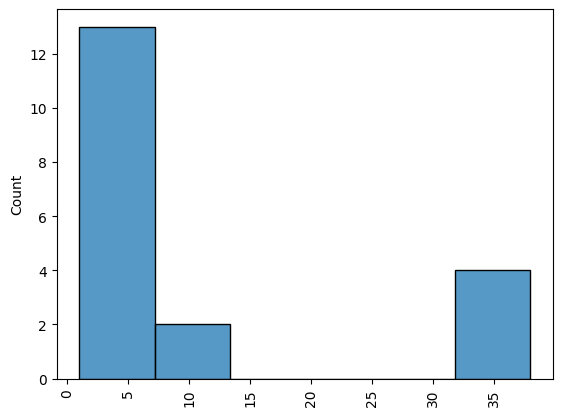

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

counter_across_patients = Counter()
for idx, row in motif_space_features.iterrows():
    counter_across_patients.update(row['features'])

g = sns.histplot(counter_across_patients)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [9]:
optimal_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                              exclude_patients=[],
                                              n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

In [10]:
optimal_result.get_roc_auc_score()

0.8916666666666667

In [18]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 19, number of hashes: 19


{12110603532: 2856578561211090970,
 2454267148: -2785496978450312591,
 2961208588: 5322849665145976878,
 15901249932: -2937209521203962343,
 21276842380: 6363102744880394829,
 1672625548: -8334768063605862937,
 1639021836: 7476495471272693903,
 1677351212: -3276004159126218973,
 4880694732: 6501729852448164872,
 16417793484: 7779624149145954569,
 20202011980: 4092891317731859338,
 4071751116: -3224596876564360443,
 3522784716: -7428170179511166437,
 15341317580: 6191483428857422447,
 20748339660: 7522159845133462507,
 11075202540: -2419085700876409031,
 17763644908: -3945035406512623651,
 11561745772: 3341299229835211946,
 11583232364: -3798811191137981739}

In [19]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator.get_patients_class(target_classes)
for motif_id in all_motif_features:
    patients_ids = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID == motif_id) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == target_classes[0]:
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

In [20]:
print(f'group a - {target_classes[0]}: {len(group_a_motifs)}')
print(f'group b - {target_classes[1]}: {len(group_b_motifs)}')

group a - NN: 8
group b - NP: 11


In [21]:
discriminator.cism.motifs_dataset['Total'] = discriminator.cism.motifs_dataset['Count']/discriminator.cism.motifs_dataset['Freq']

In [22]:
new_freq_table = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID'], observed=True)[['Count', 'Total']].sum().reset_index()

new_freq_table['Freq'] = new_freq_table['Count']/new_freq_table['Total']
motif_mean_count = new_freq_table.groupby('ID')['Freq'].mean()

In [23]:
import pandas as pd
import networkx as nx
import os
import numpy as np

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list,
                                     motifs_weight: pd.DataFrame) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            from cism.helpers import string_base64_pickle
            target_motif = string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += motifs_weight.loc[motif_id]

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

motif_id: 21276842380, hash_id: 6363102744880394829
motif_id: 1672625548, hash_id: -8334768063605862937
motif_id: 1677351212, hash_id: -3276004159126218973
motif_id: 20202011980, hash_id: 4092891317731859338
motif_id: 20748339660, hash_id: 7522159845133462507
motif_id: 17763644908, hash_id: -3945035406512623651
motif_id: 11561745772, hash_id: 3341299229835211946
motif_id: 11583232364, hash_id: -3798811191137981739


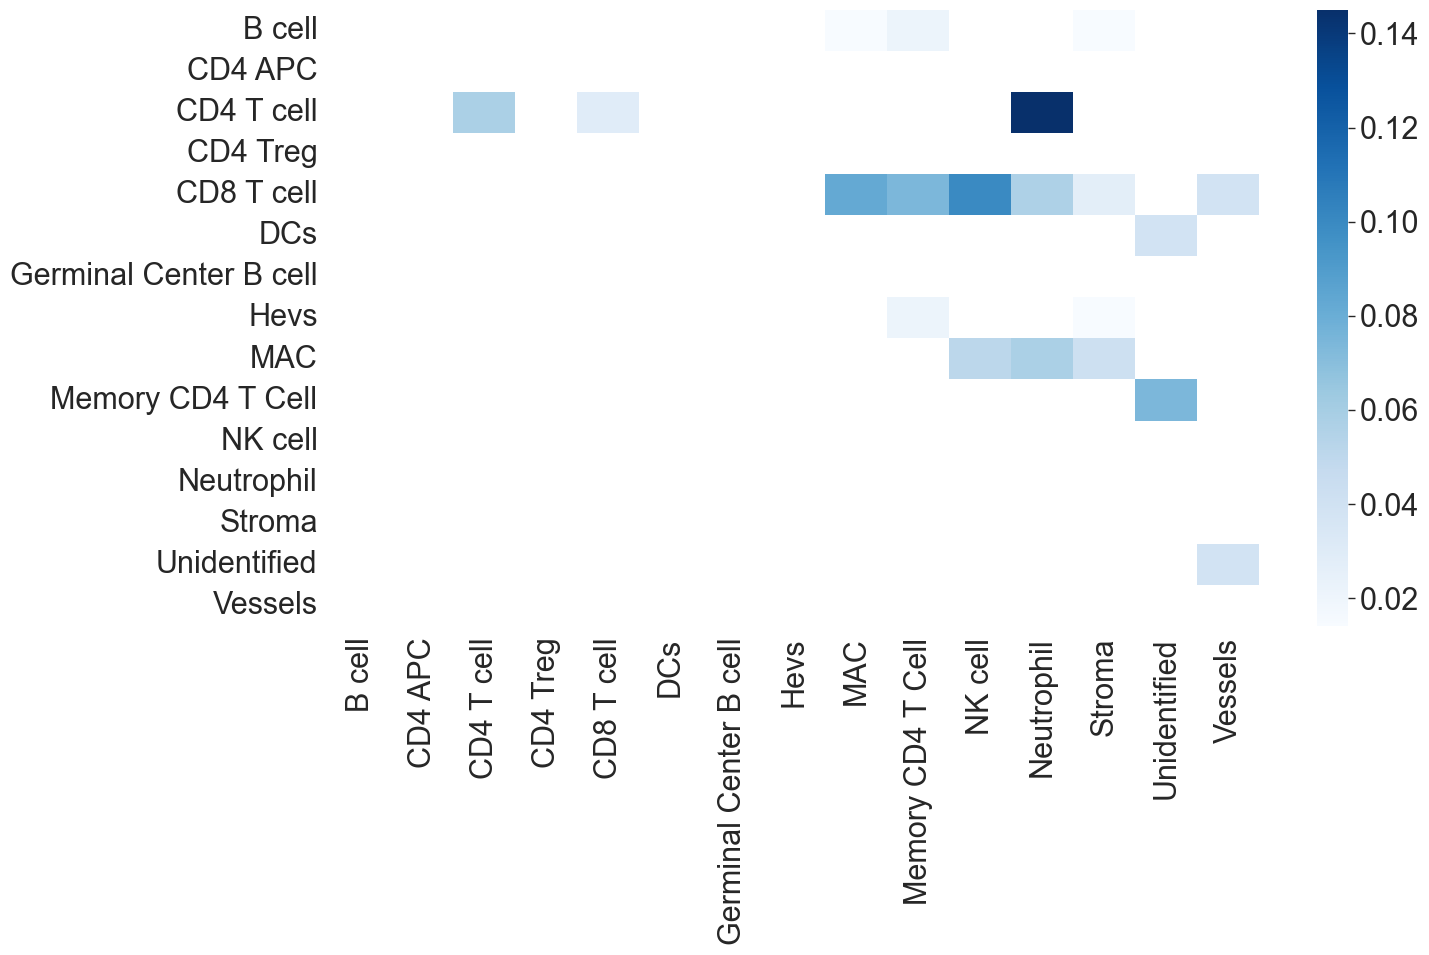

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df_a_matrix = create_weight_matrix_from_motifs(
                discriminator=discriminator,
                cells_type=cells_type,
                cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                motifs_ids=group_a_motifs,
                motifs_weight=motif_mean_count)

df_a_matrix = df_a_matrix.drop(['Tumor'], axis=1)
df_a_matrix = df_a_matrix.drop(['Tumor'], axis=0)

ax = sns.heatmap(df_a_matrix, annot=False, mask=df_a_matrix==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

motif_id: 12110603532, hash_id: 2856578561211090970
motif_id: 2454267148, hash_id: -2785496978450312591
motif_id: 2961208588, hash_id: 5322849665145976878
motif_id: 15901249932, hash_id: -2937209521203962343
motif_id: 1639021836, hash_id: 7476495471272693903
motif_id: 4880694732, hash_id: 6501729852448164872
motif_id: 16417793484, hash_id: 7779624149145954569
motif_id: 4071751116, hash_id: -3224596876564360443
motif_id: 3522784716, hash_id: -7428170179511166437
motif_id: 15341317580, hash_id: 6191483428857422447
motif_id: 11075202540, hash_id: -2419085700876409031


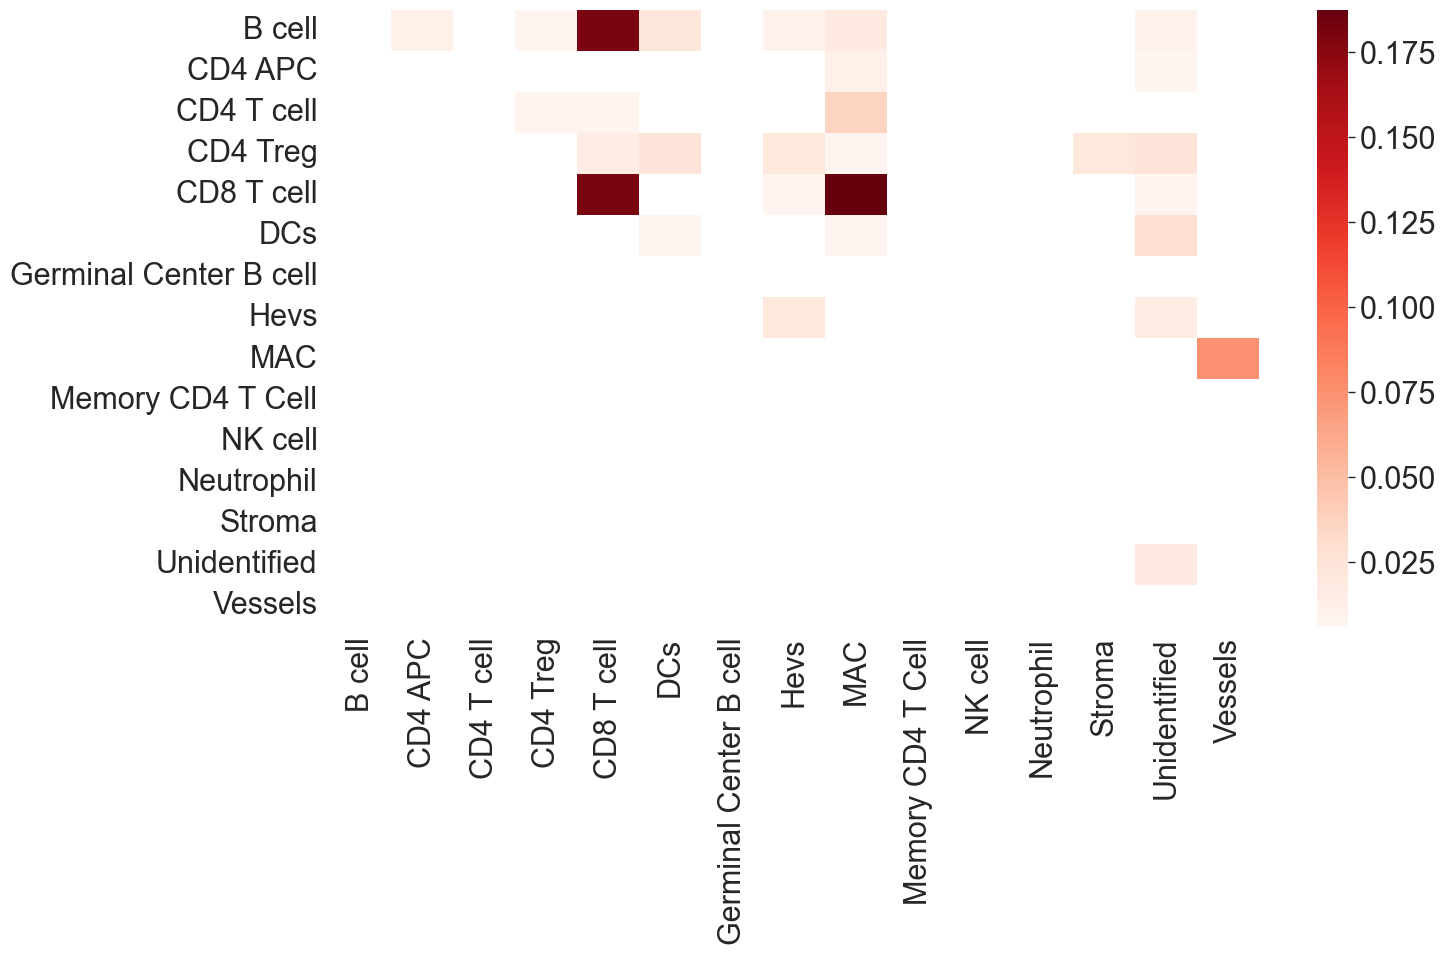

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df_b_matrix = create_weight_matrix_from_motifs(
                discriminator=discriminator,
                cells_type=cells_type,
                cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                motifs_ids=group_b_motifs,
                motifs_weight=motif_mean_count)

df_b_matrix = df_b_matrix.drop(['Tumor'], axis=1)
df_b_matrix = df_b_matrix.drop(['Tumor'], axis=0)

ax = sns.heatmap(df_b_matrix, annot=False, mask=df_b_matrix==0, cmap='Reds', annot_kws={'size': 14}, fmt=".3f")

In [27]:
print(f'NN spearman NP:')
print(stats.spearmanr(upper(df_a_matrix), upper(df_b_matrix)))

NN spearman NP:
SignificanceResult(statistic=-0.015790637411579066, pvalue=0.8729764344358347)


Structure Gain Analysis

In [21]:
from cism.structure_gain import switch_all

switch_all_roc_auc_scores = []
for trial in range(10):
    motifs_patient_map, cell_type_composition_patient_map = \
                switch_all(motif_to_cells_identity_hash=motif_to_cells_identity_hash,
                           target_motif_ids=None,
                           motif_space_features=motif_space_features,
                           include_all_motifs=False,
                           include_all_cell_identity=True)

    featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=30,
            labels=target_classes,
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                              exclude_patients=[],
                                              n_jobs=1,
                                              random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/38 [00:00<?, ?it/s]

0.6347222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

0.6833333333333333


  0%|          | 0/38 [00:00<?, ?it/s]

0.6444444444444445


  0%|          | 0/38 [00:00<?, ?it/s]

0.6263888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

0.6430555555555556


  0%|          | 0/38 [00:00<?, ?it/s]

0.6291666666666667


  0%|          | 0/38 [00:00<?, ?it/s]

0.6791666666666666


  0%|          | 0/38 [00:00<?, ?it/s]

0.6791666666666667


  0%|          | 0/38 [00:00<?, ?it/s]

0.6777777777777778


  0%|          | 0/38 [00:00<?, ?it/s]

0.6527777777777778


0.655

In [22]:
np.std(switch_all_roc_auc_scores)

0.021554195260629273

In [23]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_all(motif_to_cells_identity_hash=motif_to_cells_identity_hash,
                       target_motif_ids=motif_ids,
                       motif_space_features=motif_space_features,
                       include_all_motifs=False,
                       include_all_cell_identity=True)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=30,
            labels=target_classes,
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

  0%|          | 0/38 [00:00<?, ?it/s]

hash: 2856578561211090970, roc_auc_score: 0.6930555555555556, roc_auc_ratio: 1.2765531062124247, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2785496978450312591, roc_auc_score: 0.7125, roc_auc_ratio: 1.2417153996101364, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 5322849665145976878, roc_auc_score: 0.6750000000000002, roc_auc_ratio: 1.310699588477366, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2937209521203962343, roc_auc_score: 0.663888888888889, roc_auc_ratio: 1.3326359832635983, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6363102744880394829, roc_auc_score: 0.7236111111111112, roc_auc_ratio: 1.2226487523992322, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8334768063605862937, roc_auc_score: 0.6875, roc_auc_ratio: 1.286868686868687, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7476495471272693903, roc_auc_score: 0.7194444444444444, roc_auc_ratio: 1.2297297297297298, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3276004159126218973, roc_auc_score: 0.7652777777777778, roc_auc_ratio: 1.1560798548094373, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6501729852448164872, roc_auc_score: 0.7791666666666668, roc_auc_ratio: 1.1354723707664884, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7779624149145954569, roc_auc_score: 0.7027777777777777, roc_auc_ratio: 1.2588932806324113, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4092891317731859338, roc_auc_score: 0.6305555555555555, roc_auc_ratio: 1.4030837004405288, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3224596876564360443, roc_auc_score: 0.7944444444444444, roc_auc_ratio: 1.1136363636363638, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7428170179511166437, roc_auc_score: 0.7319444444444444, roc_auc_ratio: 1.2087286527514234, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6191483428857422447, roc_auc_score: 0.7833333333333333, roc_auc_ratio: 1.1294326241134753, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7522159845133462507, roc_auc_score: 0.6513888888888889, roc_auc_ratio: 1.3582089552238807, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2419085700876409031, roc_auc_score: 0.7458333333333335, roc_auc_ratio: 1.1862197392923648, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3945035406512623651, roc_auc_score: 0.6958333333333333, roc_auc_ratio: 1.2714570858283434, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3341299229835211946, roc_auc_score: 0.675, roc_auc_ratio: 1.3106995884773662, avg features: 19.0, std features: 0.0, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3798811191137981739, roc_auc_score: 0.6888888888888889, roc_auc_ratio: 1.2842741935483872, avg features: 19.0, std features: 0.0, number of mapped features: 1


,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
0,2856578561211090970,0.693056,0.0,[0.6930555555555556],1.276553,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,-2785496978450312591,0.712500,0.0,[0.7125],1.241715,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,5322849665145976878,0.675000,0.0,[0.6750000000000002],1.310700,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,-2937209521203962343,0.663889,0.0,[0.663888888888889],1.332636,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6363102744880394829,0.723611,0.0,[0.7236111111111112],1.222649,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
5,-8334768063605862937,0.687500,0.0,[0.6875],1.286869,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
6,7476495471272693903,0.719444,0.0,[0.7194444444444444],1.229730,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
7,-3276004159126218973,0.765278,0.0,[0.7652777777777778],1.156080,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
8,6501729852448164872,0.779167,0.0,[0.7791666666666668],1.135472,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
9,7779624149145954569,0.702778,0.0,[0.7027777777777777],1.258893,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


In [24]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
11,-3224596876564360443,0.794444,0.0,[0.7944444444444444],1.113636,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
13,6191483428857422447,0.783333,0.0,[0.7833333333333333],1.129433,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
8,6501729852448164872,0.779167,0.0,[0.7791666666666668],1.135472,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
7,-3276004159126218973,0.765278,0.0,[0.7652777777777778],1.156080,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
15,-2419085700876409031,0.745833,0.0,[0.7458333333333335],1.186220,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
12,-7428170179511166437,0.731944,0.0,[0.7319444444444444],1.208729,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6363102744880394829,0.723611,0.0,[0.7236111111111112],1.222649,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
6,7476495471272693903,0.719444,0.0,[0.7194444444444444],1.229730,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,-2785496978450312591,0.712500,0.0,[0.7125],1.241715,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
9,7779624149145954569,0.702778,0.0,[0.7027777777777777],1.258893,19.0,0.0,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


(16, 19)


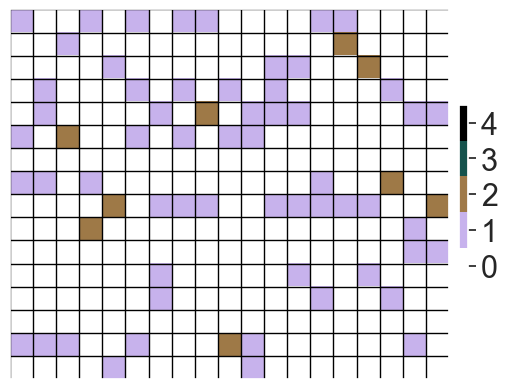

In [25]:
from cism.vis.draw import plot_colors_bar

plot_colors_bar(discriminator, ratio_gain_results, cells_type)

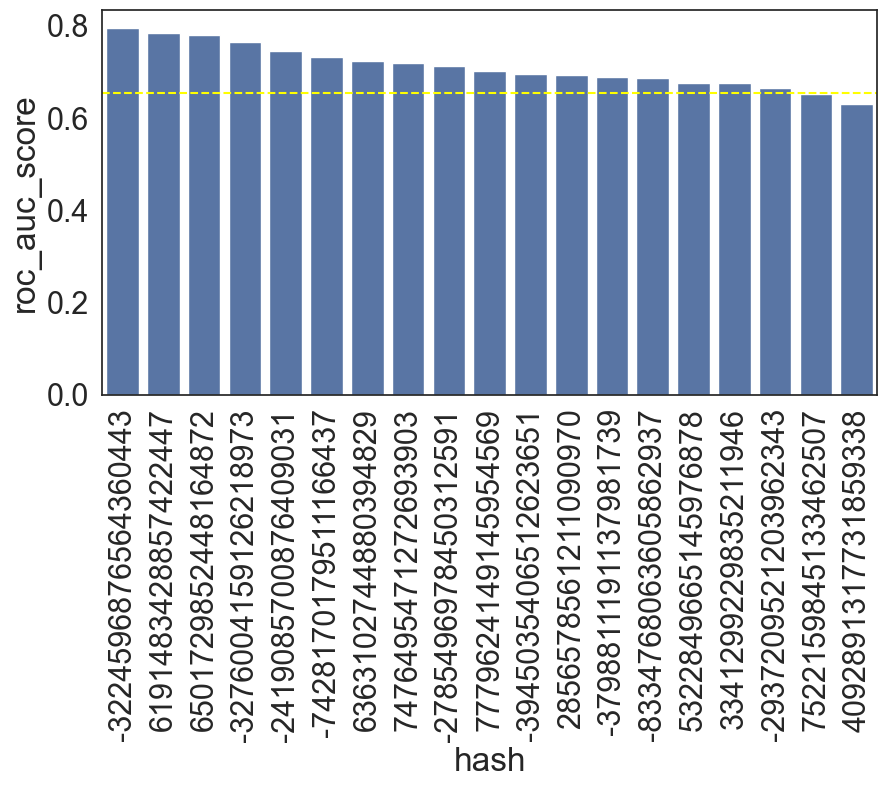

In [32]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['savefig.transparent'] = True

plt.figure(figsize=(10,5))
g = sns.barplot(ratio_gain_results, x='hash', y='roc_auc_score', order=ratio_gain_results['hash'])
sns.set_style("white")
plt.xticks(rotation=90)
g.axhline(np.mean(switch_all_roc_auc_scores), ls='--', color='yellow', ms='50')
plt.show()

In [ ]:
ratio_gain_results.to_csv(results_dir +'/' + f'ratio_gain_{target_classes_str}_{local_motif_size}_results.csv' )

In [20]:
discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID', 'colors_vec_hash'], observed=True)['Count'].sum().reset_index().to_csv(results_dir +'/' + f'{target_classes_str}_{local_motif_size}_motifs_counts_across_patients.csv')

motif_id: 4071751116, hash_id: -3224596876564360443


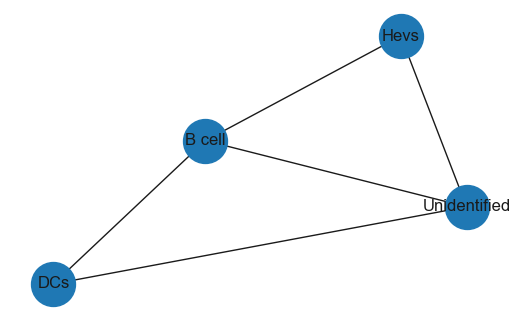

motif_id: 15341317580, hash_id: 6191483428857422447


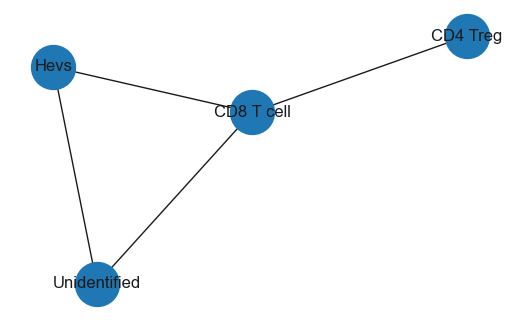

motif_id: 4880694732, hash_id: 6501729852448164872


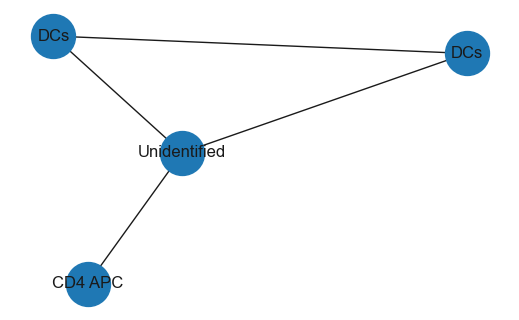

motif_id: 1677351212, hash_id: -3276004159126218973


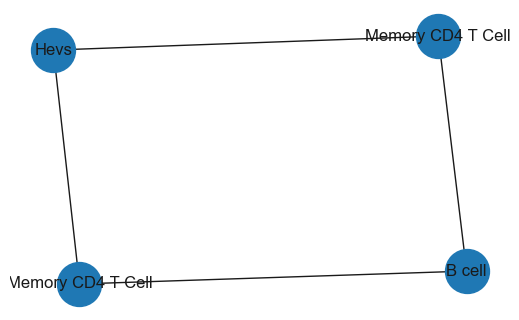

motif_id: 11075202540, hash_id: -2419085700876409031


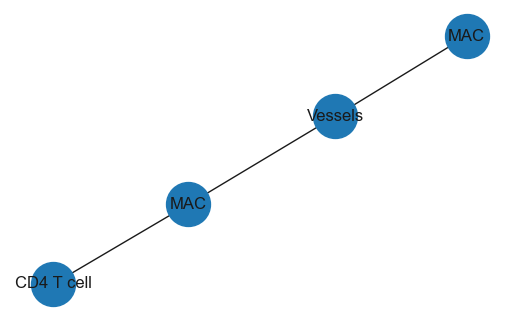

motif_id: 3522784716, hash_id: -7428170179511166437


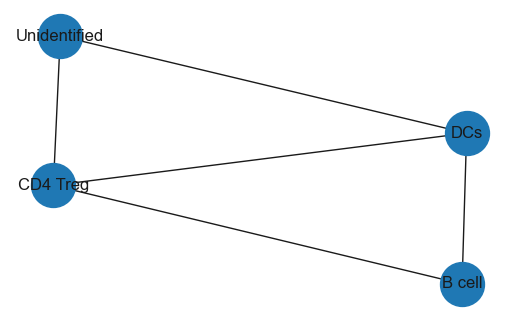

motif_id: 21276842380, hash_id: 6363102744880394829


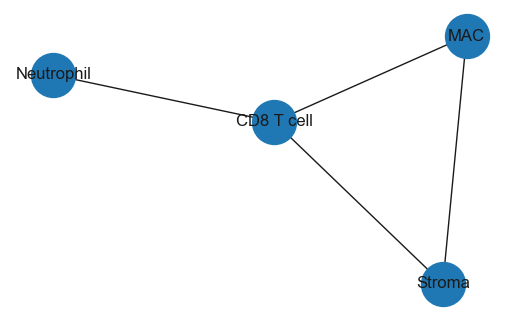

motif_id: 1639021836, hash_id: 7476495471272693903


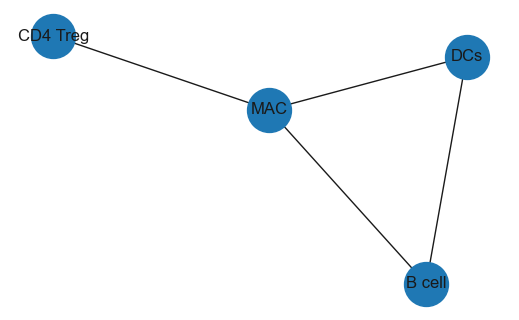

motif_id: 2454267148, hash_id: -2785496978450312591


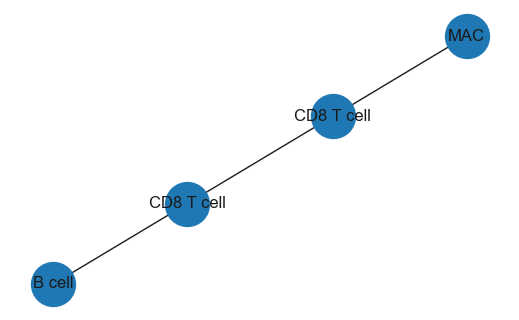

motif_id: 16417793484, hash_id: 7779624149145954569


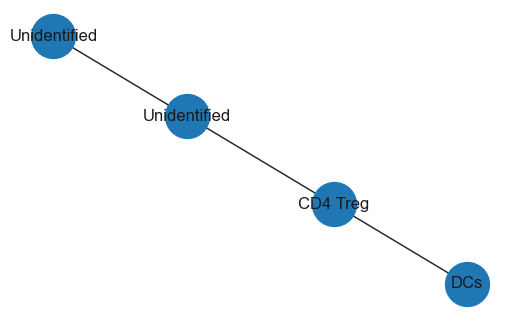

motif_id: 17763644908, hash_id: -3945035406512623651


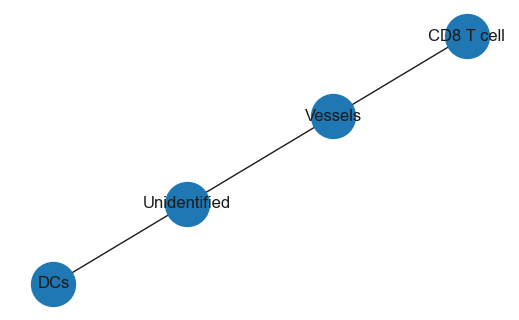

motif_id: 12110603532, hash_id: 2856578561211090970


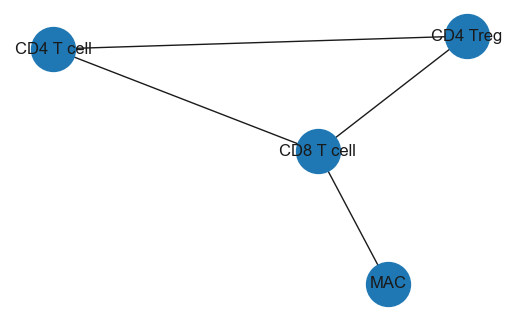

motif_id: 11583232364, hash_id: -3798811191137981739


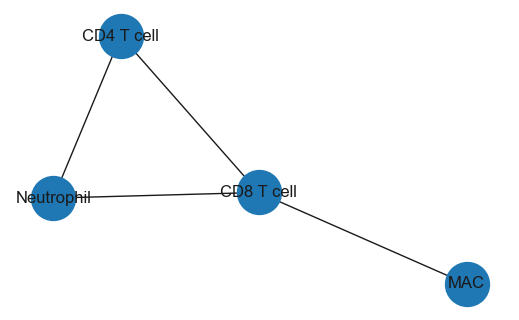

motif_id: 1672625548, hash_id: -8334768063605862937


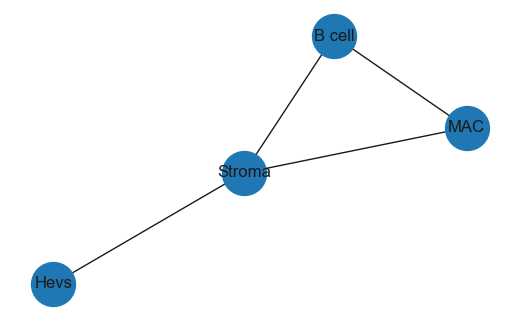

motif_id: 2961208588, hash_id: 5322849665145976878


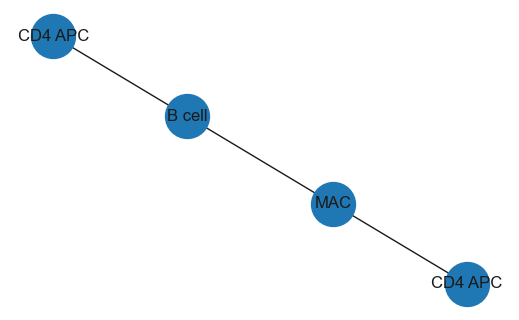

motif_id: 11561745772, hash_id: 3341299229835211946


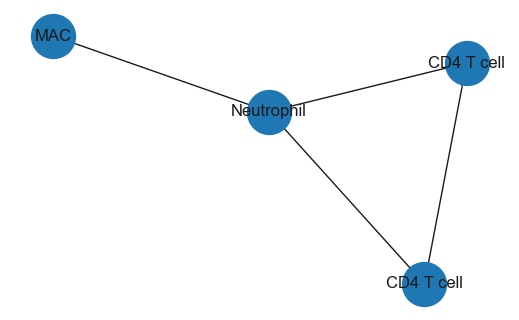

motif_id: 15901249932, hash_id: -2937209521203962343


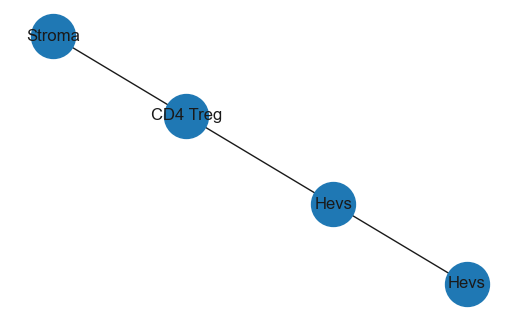

motif_id: 20748339660, hash_id: 7522159845133462507


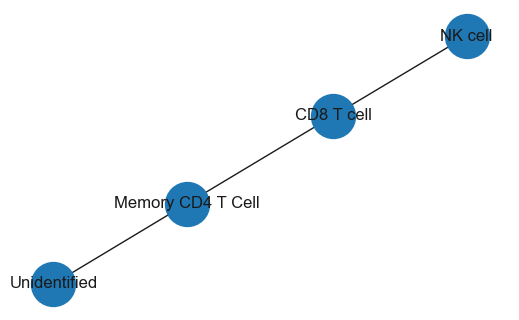

motif_id: 20202011980, hash_id: 4092891317731859338


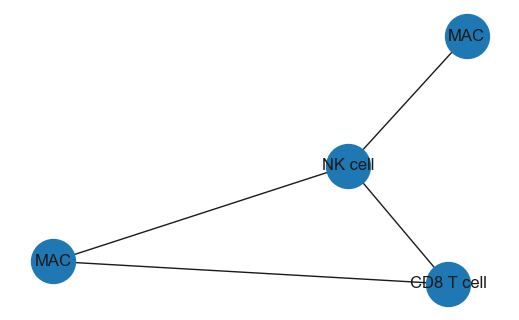

In [27]:
from cism.vis import draw

for idx, row in ratio_gain_results.iterrows():
    hash_id = ratio_gain_results.loc[idx].hash
    motifs = cell_identity_to_motif_hash[ratio_gain_results.loc[idx].hash]
    for motif_id in motifs:
        print(f'motif_id: {motif_id}, hash_id: {hash_id}')
        target_motif = cism.motifs_dataset[cism.motifs_dataset.ID == motif_id].iloc[0].motif
        target_motif = helpers.string_base64_pickle(target_motif)
        draw.draw_motif(target_motif, cells_type=cells_type)

In [46]:
base = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.colors_vec_hash.isin(cell_identity_to_motif_hash.keys())) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID', 'colors_vec_hash'], observed=False)['Count'].sum()

In [51]:
pd.concat([base.reset_index().groupby(['Patient', 'ID'], observed=False)['Count'].sum().reset_index().rename(mapper={'ID': 'feature'}, axis=1),
           base.reset_index().groupby(['Patient', 'colors_vec_hash'], observed=False)['Count'].sum().reset_index().rename(mapper={'colors_vec_hash': 'feature'}, axis=1)]).to_csv(results_dir +'/' + f'{target_classes_str}_{local_motif_size}_feature_counts_across_patients.csv')

In [57]:
feature_counts_across_patients = pd.concat([base.reset_index().groupby(['Patient', 'ID'], observed=False)['Count'].sum().reset_index().rename(mapper={'ID': 'feature'}, axis=1),
           base.reset_index().groupby(['Patient', 'colors_vec_hash'], observed=False)['Count'].sum().reset_index().rename(mapper={'colors_vec_hash': 'feature'}, axis=1)])

In [56]:
patient_class_df = discriminator.get_patients_class().reset_index().copy()
patient_class_df['index'] = patient_class_df['index'].transform(lambda x: int(x[8:]))
patient_class_df

,index,patient_class_id,patient_class
0,1,NP,NP
1,10,NP,NP
2,100,PN,PN
3,102,PP,PP
4,103,PP,PP
...,...,...,...
63,92,PN,PN
64,94,PP,PP
65,95,PN,PN
66,96,PN,PN


In [60]:
feature_counts_across_patients = pd.merge(feature_counts_across_patients, patient_class_df, left_on='Patient', right_on='index')

In [71]:
feature_counts_across_patients[feature_counts_across_patients.feature==-3276004159126218973]

,Patient,feature,Count,index,patient_class_id,patient_class
21085,1,-3276004159126218973,213.0,1,NP,NP
24859,2,-3276004159126218973,214.0,2,NP,NP
28633,3,-3276004159126218973,374.0,3,NP,NP
32407,4,-3276004159126218973,840.0,4,NP,NP
36181,5,-3276004159126218973,335.0,5,NP,NP
39955,8,-3276004159126218973,307.0,8,NP,NP
43729,9,-3276004159126218973,361.0,9,NP,NP
47503,10,-3276004159126218973,148.0,10,NP,NP
51277,11,-3276004159126218973,516.0,11,NP,NP
55051,12,-3276004159126218973,372.0,12,NP,NP


In [72]:
from scipy.stats import mannwhitneyu

group1 = feature_counts_across_patients[(feature_counts_across_patients.feature==-3276004159126218973) & (feature_counts_across_patients.patient_class == 'NN')]['Count']
group2 = feature_counts_across_patients[(feature_counts_across_patients.feature==-3276004159126218973) & (feature_counts_across_patients.patient_class == 'NP')]['Count']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(group1, group2)

print(f'Statistic: {stat}, P-value: {p_value}')

Statistic: 163.5, P-value: 0.6398616189389461


In [75]:
group1 = feature_counts_across_patients[(feature_counts_across_patients.feature==1677351212) & (feature_counts_across_patients.patient_class == 'NN')]['Count']
group2 = feature_counts_across_patients[(feature_counts_across_patients.feature==1677351212) & (feature_counts_across_patients.patient_class == 'NP')]['Count']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(group1, group2)

print(f'Statistic: {stat}, P-value: {p_value}')

Statistic: 261.0, P-value: 0.002987008336091038


In [73]:
group1 = feature_counts_across_patients[(feature_counts_across_patients.feature==-2419085700876409031) & (feature_counts_across_patients.patient_class == 'NN')]['Count']
group2 = feature_counts_across_patients[(feature_counts_across_patients.feature==-2419085700876409031) & (feature_counts_across_patients.patient_class == 'NP')]['Count']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(group1, group2)

print(f'Statistic: {stat}, P-value: {p_value}')

Statistic: 200.5, P-value: 0.558681304223271


In [76]:
group1 = feature_counts_across_patients[(feature_counts_across_patients.feature==11075202540) & (feature_counts_across_patients.patient_class == 'NN')]['Count']
group2 = feature_counts_across_patients[(feature_counts_across_patients.feature==11075202540) & (feature_counts_across_patients.patient_class == 'NP')]['Count']

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(group1, group2)

print(f'Statistic: {stat}, P-value: {p_value}')

Statistic: 101.5, P-value: 0.0032397103328001666
